# GD8. seq2seq으로 번역기 만들기
* 한국어 시각화를 위한 나눔글꼴 설치
```
$ sudo apt -qq -y install fonts-nanum
```

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from tqdm import tqdm # tqdm
import random

import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

## 데이터 전처리
### 준비하기

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [4]:
# 데아터 형태 확인

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


### 정제하기
* 데이터는 '\t' 를 delimiter로 하는 영어-스페인어 병렬 쌍
* 정제 과정에서 ¡ 등 기호 삭제
> *사실 스페인에서는 역 물음표(¿)와 역 느낌표(¡)를 일반적으로 사용합니다. 문장이 물음표나 느낌표로 끝난다면 해당 문장 맨 앞에 역으로 된 기호를 붙여준다고 해요. 이해를 돕기 위해 이상한 기호 취급을 하였으니 양해를 바랍니다!*
* 원활한 학습을 위해 데이터는 상위 3만 개만 사용

In [5]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [6]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English:", enc_corpus[100])   # go away !
print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> ¡salga de aquí ! <end>


### 토큰화

In [7]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [8]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 5104
Spanish Vocab Size: 10292


## 모델 설계
* 1개의 GRU를 갖는 Encoder-Decoder 구조 (주어진 이미지대로) 설계
    - Encoder는 모든 time-step의 hidden state를 출력으로 갖고,
    - Decoder는 Encoder의 출력과 Decoder의 t-1 step의 hidden state로 attention을 취하여 t step의 hidden state를 만들어낸다
> *"Decoder에서 t Step의 단어로 예측된 것을 실제 정답과 대조해 Loss를 구하고, 생성된 t Step의 Hidden State는 t+1 Step의 Hidden State를 만들기 위해 다시 Decoder에 전달됩니다."*
* Attention은 Bahdanau 사용
* "t=1 일 때의 Hidden State는 어떻게 정의할 것인가?": 일반적으로 Encoder의 Final State를 Hidden State로 사용

In [9]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [10]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        # TODO: Awesome Encoder Modules
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        # TODO: Awesome Process
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        # TODO: Awesome Decoder Modules
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

    def call(self, x, h_dec, enc_out):
        # TODO: Awesome Process
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [12]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 10293)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## 훈련하기 (1) Optimizer & Loss
* optimizer: 모델이 학습할 때에 정답을 찾아가는 방법. 일반적으로 adam 사용
* ```fit()``` 함수는 사용하지 않음: Encoder-Decoder 구조는 학습 과정이 일반적이지 않으므로 직접 loss를 커스텀해서 사용해야 하기 때문
* ```SparseCategoricalCrossentropy()```: 모델이 출력한 확률분포와 정수 인덱스 답안을 비교해 cross entropy 값을 구해줌 ([ 0.1, 0.2, 0.7 ] 과 [ 2 ] 를 비교하여 점수를 채점하는 식)
* ```from_logits```: 확률 분포가 Softmax를 거쳐서 들어오는 지, 모델의 출력값 그대로 들어오는지를 결정. True면 모델의 출력값을 그대로 전달

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## 훈련하기 (2) train_step 구현하기
* ```@tf.function``` 데코레이터: 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와준다
    - https://www.tensorflow.org/guide/function?hl=ko
    - 예제에서 @tf.function 를 제거할 경우, Epoch당 1.5~2배 이상 더 많은 시간 소요
* ```tf.GradientTape()```: 학습하며 발생한 모든 연산을 기록하는 테이프. 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데 사용
    - https://www.tensorflow.org/tutorials/customization/autodiff?hl=ko
* ```train_step()``` 의 학습 과정
    1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
    2. Decoder에 입력으로 전달할 \< start \> 토큰 문장 생성
    3. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]
    4. \< start \> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred
    5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
    6. 반복!

In [14]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

## 훈련하기 (3) 훈련 시작하기
* tqdm: 훈련의 진행 과정을 한 눈에 볼 수 있게 해주는 라이브러리 https://github.com/tqdm/tqdm
* ```epochs = 10``` 만큼 반복하는 루프에 진입한 후,
* 각 배치의 시작 인덱스를 ```idx_list``` 배열에 저장
* 인덱스를 섞는 방법으로 데이터 섞기 (모델이 학습을 원활하게 할 수 있도록)
* ```train_step()``` 함수에서 각 미니배치 학습 (이 함수는 학습에 필요한 것을 모두 가져가 loss를 계산한 후 반환하는 함수)
* 아래는 결과 예시

```
Epoch  1: 100%|██████████| 375/375 [01:12<00:00,  5.15it/s, Loss 1.3371] 
Epoch  2: 100%|██████████| 375/375 [00:52<00:00,  7.09it/s, Loss 0.8679] 
Epoch  3: 100%|██████████| 375/375 [00:52<00:00,  7.08it/s, Loss 0.6092] 
Epoch  4: 100%|██████████| 375/375 [00:52<00:00,  7.09it/s, Loss 0.4389] 

... 

Epoch  9: 100%|██████████| 375/375 [00:52<00:00,  7.08it/s, Loss 0.1577] 
Epoch 10: 100%|██████████| 375/375 [00:53<00:00,  7.06it/s, Loss 0.1417] 
```

In [15]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 375/375 [00:42<00:00,  8.92it/s, Loss 0.1502]


### 실습하기
* step 1에서 분리한 validation set을 사용하는 ```eval_step()``` 함수 정의
* ```train_step()``` 을 수행한 후 곧바로 ```eval_step()``` 을 진행하도록 소스 수정하고 아래와 같은 결과를 도출

```
Epoch  1: 100%|██████████| 375/375 [00:50<00:00,  7.45it/s, Loss 1.7839]
Test Epoch  1: 100%|██████████| 94/94 [00:09<00:00,  9.75it/s, Test Loss 1.4220]
Epoch  2: 100%|██████████| 375/375 [00:31<00:00, 11.74it/s, Loss 1.2333]
Test Epoch  2: 100%|██████████| 94/94 [00:02<00:00, 46.58it/s, Test Loss 1.1305]
Epoch  3: 100%|██████████| 375/375 [00:31<00:00, 11.77it/s, Loss 0.9801]
Test Epoch  3: 100%|██████████| 94/94 [00:01<00:00, 48.42it/s, Test Loss 0.9771]
Epoch  4: 100%|██████████| 375/375 [00:31<00:00, 11.74it/s, Loss 0.7998]
Test Epoch  4: 100%|██████████| 94/94 [00:02<00:00, 46.70it/s, Test Loss 0.8701]
Epoch  5: 100%|██████████| 375/375 [00:31<00:00, 11.81it/s, Loss 0.6553]
Test Epoch  5: 100%|██████████| 94/94 [00:01<00:00, 47.60it/s, Test Loss 0.7903]
```

In [16]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 94/94 [00:03<00:00, 28.94it/s, Test Loss 0.8394]


Input: can i have some coffee ?
Predicted translation: ¿me dan un poco de comer ? <end> 


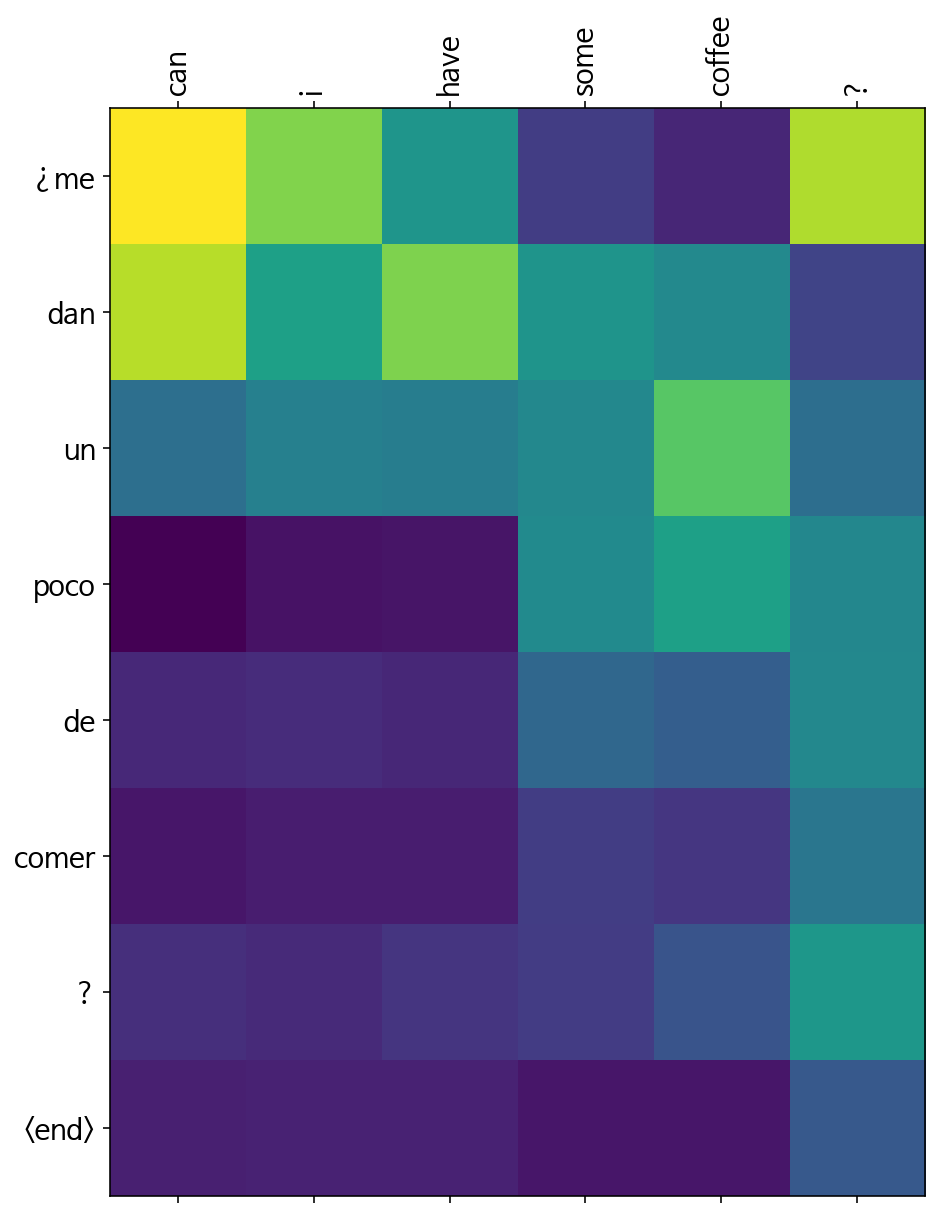

In [17]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)

## 프로젝트: 한영 번역기 만들기

### 데이터 다운로드
* https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

In [18]:
# 1. train data

### 1) Korean
train_ko_path = 'korean-english-park.train.ko'

with open(train_ko_path, "r") as f:
    train_ko_raw = f.read().splitlines()

print("Data Size:", len(train_ko_raw))
print("Example:")

for sen in train_ko_raw[0:100][::20]: print(">>", sen)
    
### 2) English
train_en_path = 'korean-english-park.train.en'

with open(train_en_path, "r") as f:
    train_en_raw = f.read().splitlines()

print("Data Size:", len(train_en_raw))
print("Example:")

for sen in train_en_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give th

### 데이터 정제
* ```set()```을 활용해 중복 제거 후, ```cleaned_corpus```에 저장할 것
    - pandas의 ```drop_duplicates()``` 로 대체 https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html
* 전처리를 위해 정의한 함수에 한글 처리 정규식 추가
* 영어 (타겟 언어) 엔 \< start \>, \< end \> 토큰 추가 후 ```split()``` 으로 토큰화
* 한글은 KoNLPy의 ```mecab``` 클래스 사용해 토큰화
* ```cleaned_corpus```로부터 토큰 길이가 40 이하인 데이터를 선별

In [19]:
print('before:', len(train_ko_raw))

# 중복 제거를 위해 dataframe 생성
train_raw = pd.DataFrame({'ko': train_ko_raw, 'en': train_en_raw})
# train_raw.drop_duplicates(subset=['ko'], inplace=True)
# 두 언어 모두 같은 문장일 때만 중복으로 보고 제거
train_raw.drop_duplicates(inplace=True)

print('after:', len(train_raw))

train_raw.head()

before: 94123
after: 78968


,ko,en
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


In [20]:
# cleaned_corpus 생성
cleaned_corpus_ko = list(train_raw['ko'])
cleaned_corpus_en = list(train_raw['en'])

print(cleaned_corpus_ko[20])
print(cleaned_corpus_en[20])

북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.


In [21]:
from konlpy.tag import Mecab
mecab = Mecab()

def preprocess_sentence(sentence, lang, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한글 처리를 위한 정규식 포함
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
        
    if lang == 'ko':
        sentence = mecab.morphs(sentence)
    elif lang == 'en':
        sentence = sentence.split()
    else:
        print('please choose only <ko> and <en>.')
    
    return sentence

In [22]:
len_limit = 25 # 문제에 주어진 40으로 하면 OOM으로 학습이 안 되는 관계로 축소

# Encoder: Korean / Decoder: English
enc_corpus = []
dec_corpus = []

# num_examples = 30000
num_examples = len(cleaned_corpus_ko)

for idx, row in enumerate(cleaned_corpus_ko[:num_examples]):
    # if len(row) + len(cleaned_corpus_en[idx]) <= len_limit:
    if len(row) <= len_limit:
        enc_corpus.append(preprocess_sentence(row, lang='ko'))
        dec_corpus.append(preprocess_sentence(cleaned_corpus_en[idx], lang='en', s_token=True, e_token=True))

print("length of enc_corpus: ", len(enc_corpus))
print("-> Korean, preprocessed example:", enc_corpus[100])
print('\n')
print("length of dec_corpus: ", len(dec_corpus))
print("-> English, preprocessed example:", dec_corpus[100])

length of enc_corpus:  5204
-> Korean, preprocessed example: ['상업', '과', '지구', '가', '모두', '번성', '할', '수', '있', '다', '.']


length of dec_corpus:  5204
-> English, preprocessed example: ['<start>', 'both', 'commerce', 'and', 'the', 'planet', 'can', 'prosper', '.', '<end>']


### 데이터 토큰화
* 실습 시 만들어놓은 ```tokenize()``` 활용
* *난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.*

In [23]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean (Encoder) Vocab Size:", len(enc_tokenizer.index_word))
print("English (Decoder) Vocab Size:", len(dec_tokenizer.index_word))

Korean (Encoder) Vocab Size: 7392
English (Decoder) Vocab Size: 8251


### 모델 설계

In [24]:
# 코드를 실행하세요.

# BATCH_SIZE     = 64
BATCH_SIZE     = 32
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (32, 30, 1024)
Decoder Output: (32, 8252)
Decoder Hidden State: (32, 1024)
Attention: (32, 30, 1)


In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

### 훈련하기
* ```train_step()``` 은 위에서 정의한 함수 그대로 사용

```
## 예문 ##
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
E1) obama is the president . <end>
E2) people are victims of the city . <end>
E2) the price is not enough . <end>
E2) seven people have died . <end>
```

In [26]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [27]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 131/131 [00:40<00:00,  3.23it/s, Loss 0.4818]


In [28]:
def evaluate_k2e(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence, lang='ko')
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

def translate_k2e(sentence, encoder, decoder):
    result, sentence, attention = evaluate_k2e(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: how to have competed against her full news <end> 


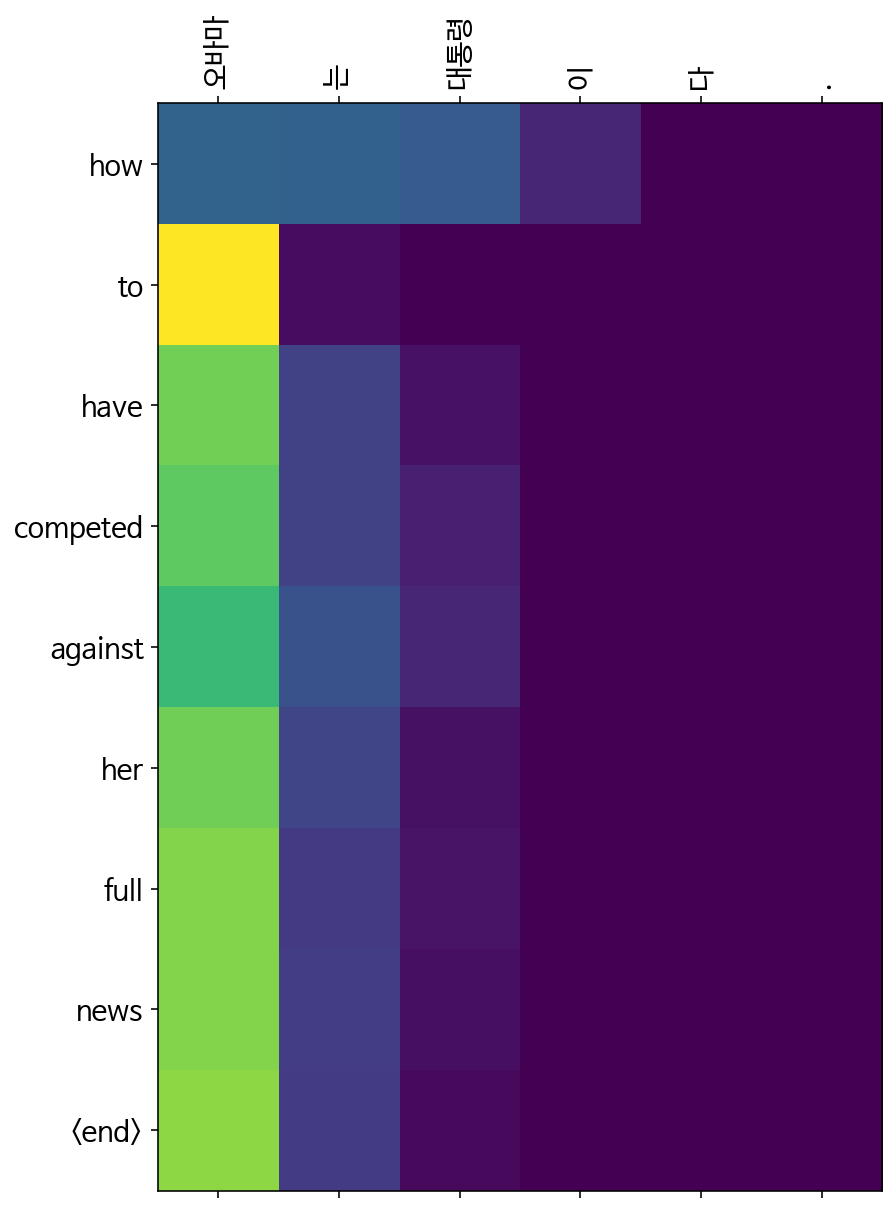

In [29]:
translate_k2e("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the rspb has eaten into their reserves . <end> 


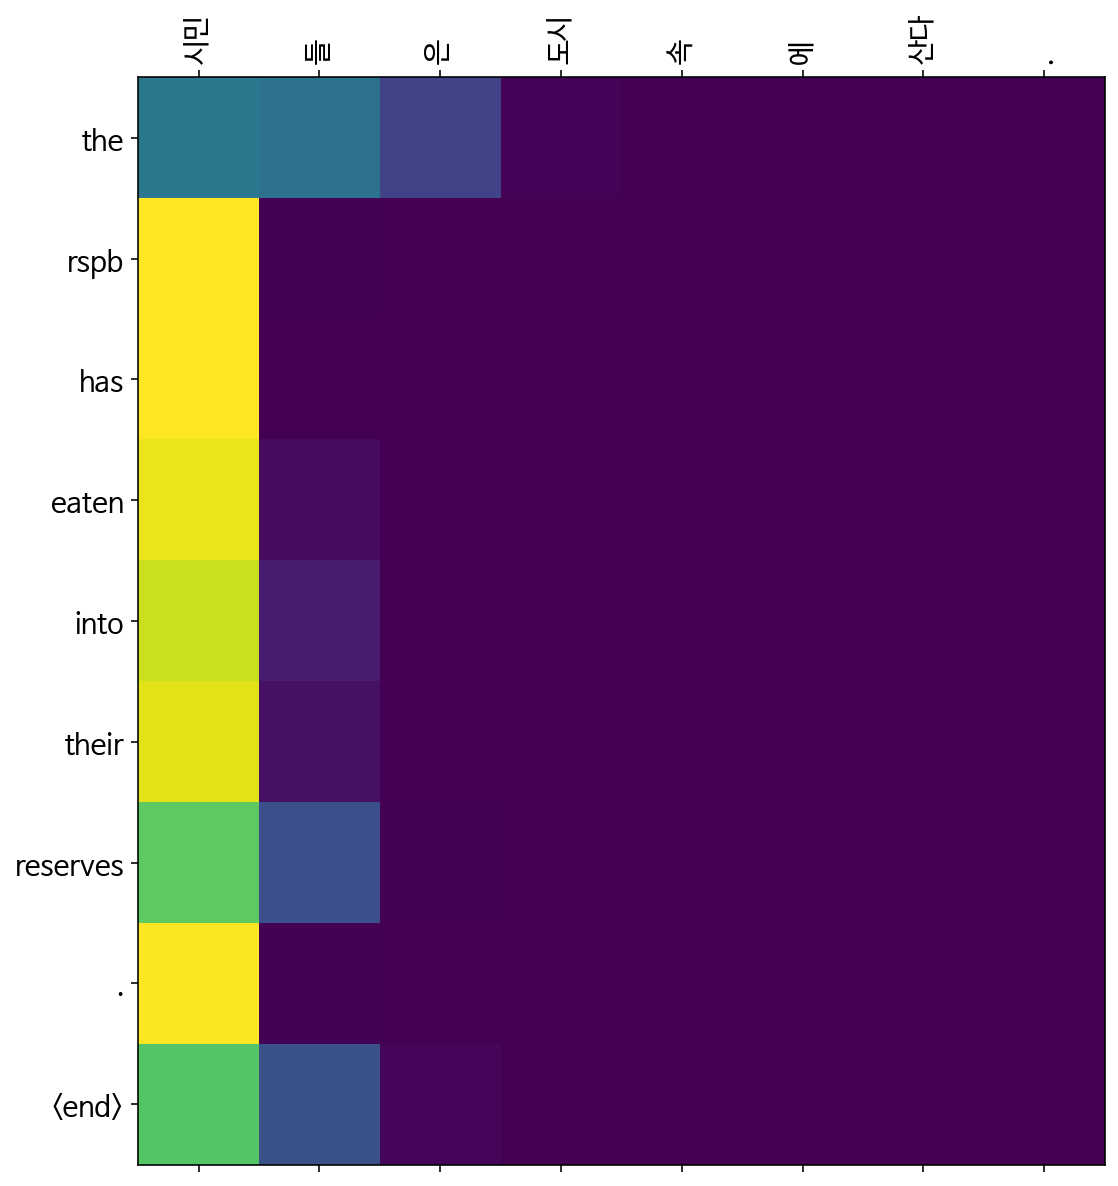

In [30]:
translate_k2e("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the referee no option . <end> 


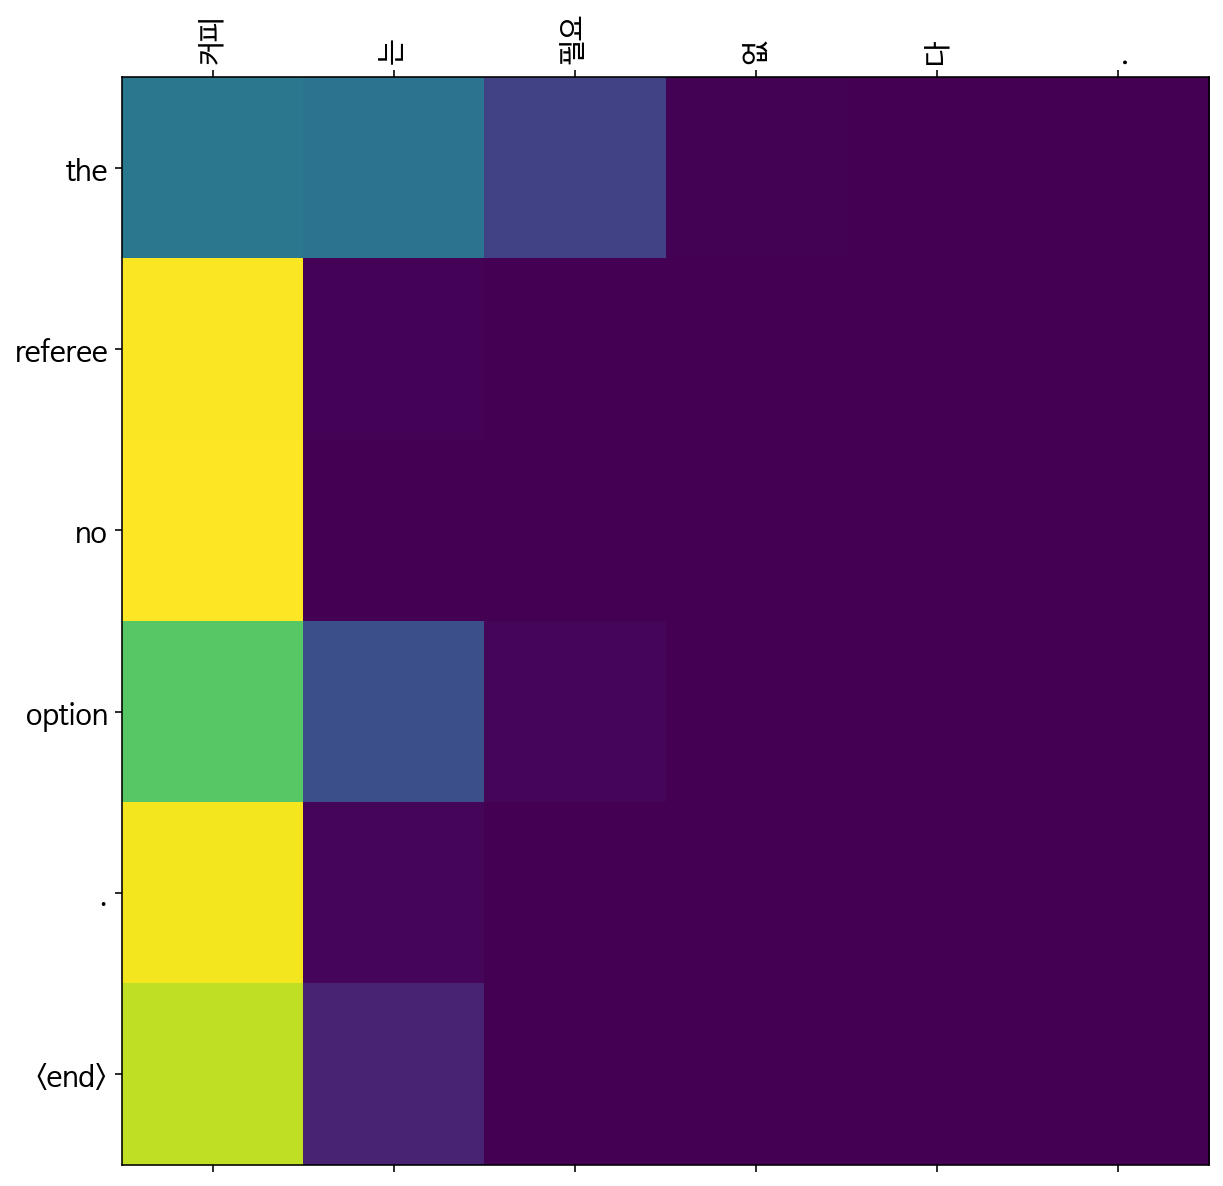

In [31]:
translate_k2e("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the country s engineering science and the country s engineering science and the country s engineering science and the country s engineering science and the country s engineering science and the country s engineering science and the country s engineering science and the country s engineering science and the country s engineering science and the country s engineering science and the country s engineering science and the country s engineering science 


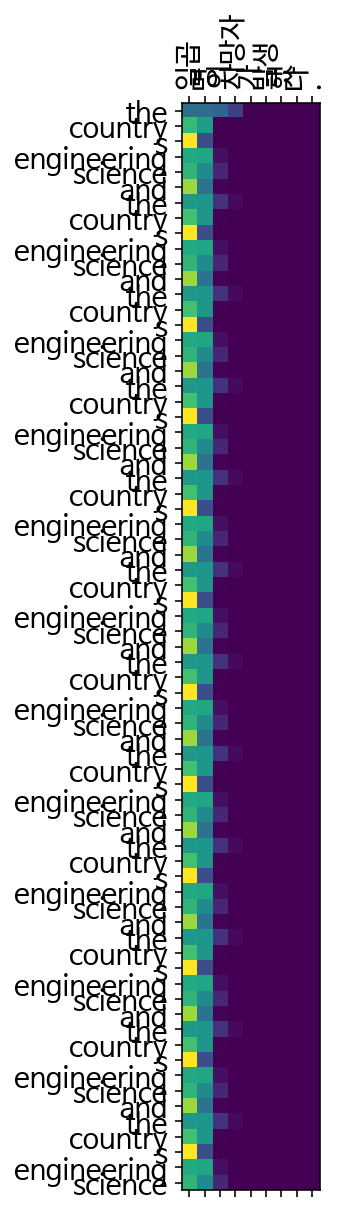

In [34]:
translate_k2e("일곱 명의 사망자가 발생했다.", encoder, decoder)

### 프로젝트: 정리
* 전처리 함수의 정규표현식에 한글 (```가-힣ㄱ-ㅎㅏ-ㅣ```) 을 포함했다.
* 중복의 판단 기준이 모호했다. 퍼실, 팀원 등과의 논의를 통해 한국어와 영어 문장 모두 같을 경우를 중복으로 보고 제거했다. ```set()``` 대신 pandas의 ```drop_duplicates()``` 를 활용했다.
* 주어진 조건대로 토큰의 길이가 40 이하인 데이터까지를 대상으로 하니 OOM으로 학습이 동작하지 않았다. 그래서 ```len_limit``` 을 부득이하게 25로 설정했다.
* 원활한 훈련을 위해 ```BATCH_SIZE``` 를 32로 줄였다.
* 대상 데이터가 제한적이어서인지 번역 결과가 썩 정확하지는 않은 편이었다.